In [1]:
import warnings
import numpy as np

import scipy.signal as sg
import scipy.integrate as ig

%matplotlib widget
import matplotlib.pyplot as plt
from matplotlib import gridspec



In [3]:
# B = np.loadtxt(path + f'/m{m}_dx{dxs[2]}_xMax70.0/outputs/B.dat',     skiprows=sr, max_rows=mr)
# E = np.loadtxt(path + f'/m{ms[0]}_dx{dx}_xMax70.0/outputs/E.dat',     skiprows=sr, max_rows=mr)

In [4]:
path = '/home/lorenzo/phd/LQG/FullDynamics/sims'

M = [5.0, 7.0, 8.0, 9.0, 10.0, 20.0, 30.0, 40.0]
#dxs = [0.01, 0.005, 0.0025]
dx = 0.005


sr = 0
mr = 8000

skipped = 10

main_peak = {}
second_peak = {}
third_peak = {}

for m in M:

    p1 = []
    p2 = []
    p3 = []

    with warnings.catch_warnings():
        warnings.filterwarnings("ignore",category=UserWarning)
        x = np.loadtxt(path + f'/m{m}_dx{dx}_xMax70.0/outputs/xs.dat')
        r = np.loadtxt(path + f'/m{m}_dx{dx}_xMax70.0/outputs/rho.dat',   skiprows=sr, max_rows=mr)
        t = np.loadtxt(path + f'/m{m}_dx{dx}_xMax70.0/outputs/times.dat', skiprows=sr, max_rows=mr)

    for idx in range(len(r)):
        idx_MAX = sg.find_peaks(r[idx, skipped:], height=[1e-2], distance=2)[0][::-1]

        if len(idx_MAX) == 1:
            p1.append([t[idx, 0], x[skipped+idx_MAX[0]], skipped+idx_MAX[0]])
            p2.append([t[idx, 0], np.NaN, np.NaN])
            p3.append([t[idx, 0], np.NaN, np.NaN])
        elif len(idx_MAX)  == 2:
            p1.append([t[idx, 0], x[skipped+idx_MAX[0]], skipped+idx_MAX[0]])
            p2.append([t[idx, 0], x[skipped+idx_MAX[1]], skipped+idx_MAX[1]])
            p3.append([t[idx, 0], np.NaN, np.NaN])
        elif len(idx_MAX)  == 3:
            p1.append([t[idx, 0], x[skipped+idx_MAX[0]], skipped+idx_MAX[0]])
            p2.append([t[idx, 0], x[skipped+idx_MAX[1]], skipped+idx_MAX[1]])
            p3.append([t[idx, 0], x[skipped+idx_MAX[2]], skipped+idx_MAX[2]])
        else:
            pass
            # print("too many peaks!")

    main_peak[m]   = np.array(p1)
    second_peak[m] = np.array(p2)
    third_peak[m]  = np.array(p3)

    second_peak[m][second_peak[m][:,0] < 50, 1:] = np.NaN
    third_peak[m][third_peak[m][:,0] < 220, 1:] = np.NaN

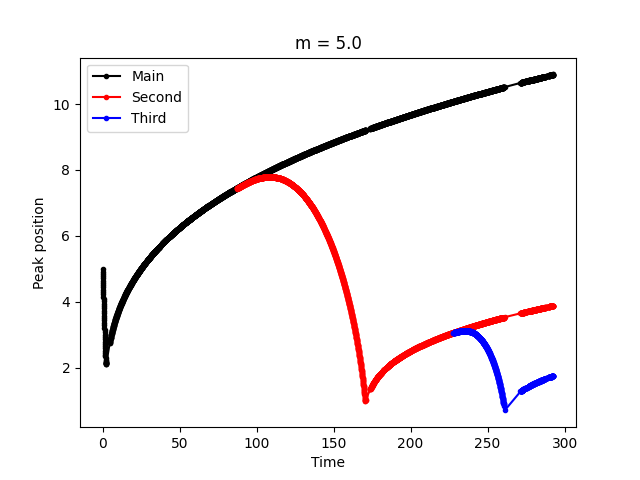

In [5]:
fig = plt.figure()

id = M[0]

plt.plot(main_peak[id][:,0], main_peak[id][:,1], '.-', color = 'k', label = 'Main')
plt.plot(second_peak[id][:,0], second_peak[id][:,1], '.-', color = 'r', label = 'Second')
plt.plot(third_peak[id][:,0], third_peak[id][:,1], '.-', color = 'b', label = 'Third')

plt.xlabel("Time")
plt.ylabel("Peak position")

plt.title(f'm = {id}')
plt.legend()


In [6]:
first_index = []
peaks = []
time_pos = []

for id in M:
    for i in range(len(second_peak[id][:,1])):
        if not np.isnan(second_peak[id][i,1]):
            print(f'm = {id}; time = {second_peak[id][i,0]}, position = {second_peak[id][i,1]}, index = {i}')
            first_index.append(i)
            peaks.append(second_peak[id][i,1])
            time_pos.append(second_peak[id][i,0])
            break

m = 5.0; time = 87.25005000233463, position = 7.4350005, index = 1705
m = 7.0; time = 111.90005000315293, position = 9.0650005, index = 2198
m = 8.0; time = 123.55005000353967, position = 9.8050005, index = 2431
m = 9.0; time = 134.80005000198042, position = 10.505000500000001, index = 2655
m = 10.0; time = 145.85004999920665, position = 11.175000500000001, index = 2876
m = 20.0; time = 243.7000499746443, position = 16.7400005, index = 4833
m = 30.0; time = 324.7500499542991, position = 21.105000500000003, index = 6453
m = 40.0; time = 393.4000499370665, position = 24.770000500000002, index = 7825


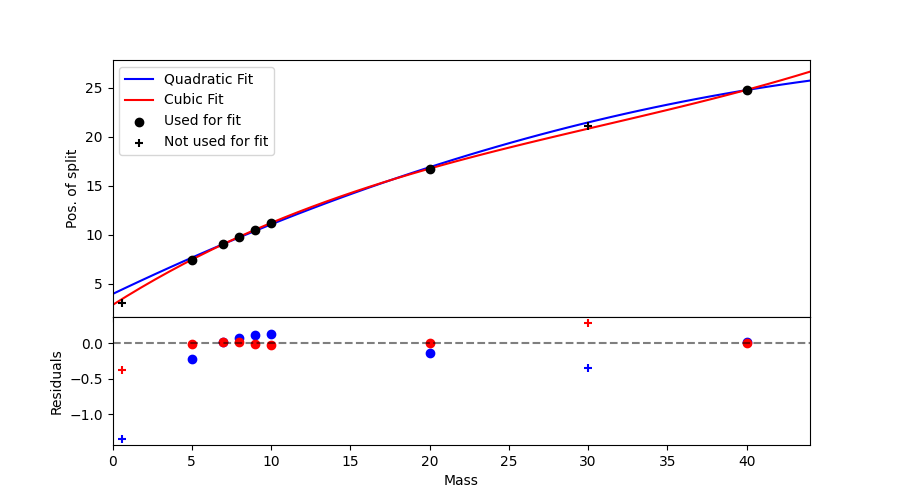

Quadratic best fit parameters: (-0.006 +- 0.001) x^2 + (0.773 +- 0.03) x + (3.944 +- 0.222)
Cubic best fit parameters: (0.00023 +- 1e-05) x^3 + (-0.021 +- 0.00095) x^2 + (1.023 +- 0.01666) x + (2.828 +- 0.07796)



In [7]:
from scipy.optimize import curve_fit
# def lin(x, a, b):
#     return a*x + b
def quad(x, a, b, c):
    return a*x**2 + b*x + c
def cubic(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

mask = np.array([True, True, True, True, True, True, False, True])
peak_pos = np.array(peaks)[mask]
ms = np.array(M)[mask]

G_pos = np.array(peaks)[~mask]
G_mas = np.array(M)[~mask]

mass_measure = np.array([0.59])
peak_measure = np.array([3.05])

# lopt, lcov = curve_fit(lin, ms, peak_pos)
qopt, qcov = curve_fit(quad, ms, peak_pos)
copt, ccov = curve_fit(cubic, ms, peak_pos)

mm = np.linspace(0, 1.1*ms[-1])

fig = plt.figure(figsize=(9,5))
gs = gridspec.GridSpec(2, 1, height_ratios=[2, 1]) 

ax0 = plt.subplot(gs[0])
ax0.plot(mm, quad(mm, *qopt), color = 'b', zorder = 1, label = 'Quadratic Fit')
ax0.plot(mm, cubic(mm, *copt), color = 'r', zorder = 1, label = 'Cubic Fit')

ax0.scatter(ms, peak_pos, color = 'k', marker='o', zorder = 2, label = 'Used for fit')
ax0.scatter(G_mas, G_pos, color = 'k', marker='+', zorder = 2, label = 'Not used for fit')
ax0.scatter(mass_measure, peak_measure, color = 'k', zorder = 2, marker='+')
# ax0.plot([20, 40], [15.226,20.156], 'x', label = 'Quadratic Prediction')
# ax0.plot([20, 40], [18.029, 35.237],'x', label = 'Cubic Prediction' )

ax0.set_ylabel('Pos. of split')
ax0.set_xlim(0, 1.1*ms[-1])

ax0.legend()

###############
### RESIDUALS
###############

ax1 = plt.subplot(gs[1], sharex = ax0)

ax1.axhline(0, ls = '--', color = 'k', alpha = 0.5)
# Residuals of fitted points
ax1.scatter(ms, -quad(ms, *qopt) + peak_pos, color = 'b')
ax1.scatter(ms, -cubic(ms, *copt) + peak_pos, color = 'r')
# Residuals of control points
ax1.scatter(G_mas, -quad(G_mas, *qopt) + G_pos,  marker = '+', color = 'b')
ax1.scatter(G_mas, -cubic(G_mas, *copt) + G_pos, marker = '+',  color = 'r')
ax1.scatter(mass_measure, -quad(mass_measure, *qopt) + peak_measure,  marker = '+', color = 'b')
ax1.scatter(mass_measure, -cubic(mass_measure, *copt) + peak_measure, marker = '+',  color = 'r')

ax1.set_xlabel('Mass')
ax1.set_ylabel('Residuals')

ax1.set_xlim(0, 1.1*ms[-1])

# remove vertical gap between subplots
plt.setp(ax0.get_xticklabels(), visible=False)
plt.subplots_adjust(hspace=.0)
plt.show()

# Errors in parameters
s_qcov = np.round(np.sqrt(np.diagonal(qcov)), 3)
s_ccov = np.round(np.sqrt(np.diagonal(ccov)), 5)

text_quad = f"Quadratic best fit parameters: ({np.round(qopt[0],3)} +- {s_qcov[0]}) x^2 + ({np.round(qopt[1],3)} +- {s_qcov[1]}) x + ({np.round(qopt[2],3)} +- {s_qcov[2]})"
text_cubic = f"Cubic best fit parameters: ({np.round(copt[0],5)} +- {s_ccov[0]}) x^3 + ({np.round(copt[1],3)} +- {s_ccov[1]}) x^2 + ({np.round(copt[2],3)} +- {s_ccov[2]}) x + ({np.round(copt[3],3)} +- {s_ccov[3]})"

print(text_quad)
print(text_cubic)
print()

In [9]:
np.savetxt('./fits/cubic_opt.dat', copt)
np.savetxt('./fits/cubic_cov.dat', ccov)
np.savetxt('./fits/quadr_opt.dat', qopt)
np.savetxt('./fits/quadr_cov.dat', qcov)

## Post

In [10]:
import numpy as np
import scipy.signal as sg

import matplotlib.pyplot as plt
%matplotlib widget

def quad(x, a, b, c):
    return a*x**2 + b*x + c
def cubic(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

copt = np.loadtxt('./fits/cubic_opt.dat')
ccov = np.loadtxt('./fits/cubic_cov.dat')
qopt = np.loadtxt('./fits/quadr_opt.dat')
qcov = np.loadtxt('./fits/quadr_cov.dat')

In [11]:
print(f'Quadratic prediction for m={0.5911875} : {quad(0.5911875, *qopt)}')
print(f'Cubic prediction for m={0.5911875} : {cubic(0.5911875, *copt)}')

Quadratic prediction for m=0.5911875 : 4.399306176302657
Cubic prediction for m=0.5911875 : 3.4251677829205893


## Start from post

In [5]:
skipped = 10

main_peak   = {}
second_peak = {}
third_peak  = {}

for j in [1, 2]:

    p1 = []
    p2 = []
    p3 = []

    if j == 1:
        sr = 0
        mr = 40000
        path = '/home/lorenzo/phd/LQG/ForwardID/sims'
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore",category=UserWarning)
            x = np.loadtxt(path + f'/m{5.0}_dx{0.005}_xMax70.0_tf200.0_r02.14_a05.7066/outputs/xs.dat')
            r = np.loadtxt(path + f'/m{5.0}_dx{0.005}_xMax70.0_tf200.0_r02.14_a05.7066/outputs/rho.dat',   skiprows=sr, max_rows=mr)
            t = np.loadtxt(path + f'/m{5.0}_dx{0.005}_xMax70.0_tf200.0_r02.14_a05.7066/outputs/times.dat', skiprows=sr, max_rows=mr)

    elif j == 2:
        sr = 0
        mr = 8000
        path = '/home/lorenzo/phd/LQG/FullDynamics/sims'
        with warnings.catch_warnings():
            warnings.filterwarnings("ignore",category=UserWarning)
            x = np.loadtxt(path + f'/m{5.0}_dx{0.005}_xMax70.0_tf400.0_r05_a013.3/outputs/xs.dat')
            r = np.loadtxt(path + f'/m{5.0}_dx{0.005}_xMax70.0_tf400.0_r05_a013.3/outputs/rho.dat',   skiprows=sr, max_rows=mr)
            t = np.loadtxt(path + f'/m{5.0}_dx{0.005}_xMax70.0_tf400.0_r05_a013.3/outputs/times.dat', skiprows=sr, max_rows=mr)

    for idx in range(len(r)):
        idx_MAX = sg.find_peaks(r[idx, skipped:], height=[1e-2], distance=2)[0][::-1]

        if len(idx_MAX) == 1:
            p1.append([t[idx, 0], x[skipped+idx_MAX[0]], skipped+idx_MAX[0]])
            p2.append([t[idx, 0], np.NaN, np.NaN])
            p3.append([t[idx, 0], np.NaN, np.NaN])
        elif len(idx_MAX)  == 2:
            p1.append([t[idx, 0], x[skipped+idx_MAX[0]], skipped+idx_MAX[0]])
            p2.append([t[idx, 0], x[skipped+idx_MAX[1]], skipped+idx_MAX[1]])
            p3.append([t[idx, 0], np.NaN, np.NaN])
        elif len(idx_MAX)  == 3:
            p1.append([t[idx, 0], x[skipped+idx_MAX[0]], skipped+idx_MAX[0]])
            p2.append([t[idx, 0], x[skipped+idx_MAX[1]], skipped+idx_MAX[1]])
            p3.append([t[idx, 0], x[skipped+idx_MAX[2]], skipped+idx_MAX[2]])
        else:
            pass
            # print("too many peaks!")

    main_peak[j]  = np.array(p1)
    second_peak[j] = np.array(p2)
    third_peak[j]  = np.array(p3)

    second_peak[j][second_peak[j][:,0] < 50, 1:] = np.NaN
    third_peak[j][third_peak[j][:,0] < 220, 1:] = np.NaN

m = 5.0; time = 85.96505000229197, position = 7.4650005, index = 16761
m = 5.0; time = 84.90005000233464, position = 7.4350005, index = 1705


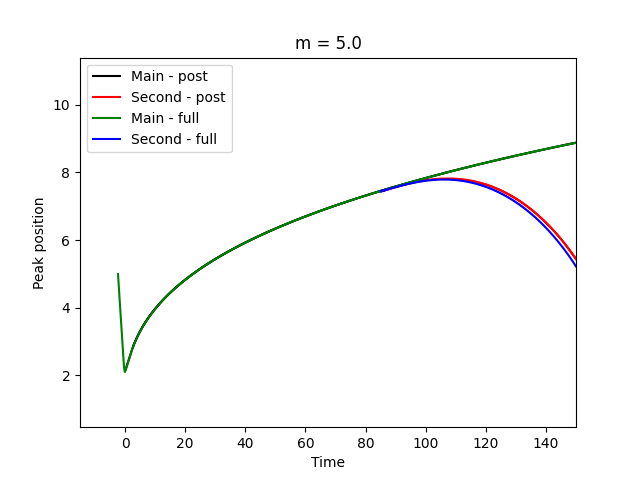

In [11]:
fig = plt.figure()

plt.plot(main_peak[1][:,0], main_peak[1][:,1], '-', color = 'k', label = 'Main - post')
plt.plot(second_peak[1][:,0], second_peak[1][:,1], '-', color = 'r', label = 'Second - post')

plt.plot(main_peak[2][:,0] - 2.35, main_peak[2][:,1], '-', color = 'g', label = 'Main - full')
plt.plot(second_peak[2][:,0] - 2.35, second_peak[2][:,1], '-', color = 'b', label = 'Second - full')

# plt.plot(third_peak[:,0], third_peak[:,1], '.-', color = 'b', label = 'Third')

plt.xlim(-15, 150)
plt.xlabel("Time")
plt.ylabel("Peak position")

plt.title(f'm = {5.0}')
plt.legend()

for j in [1,2]:
    for i in range(len(second_peak[j][:,1])):
        if not np.isnan(second_peak[j][i,1]):
            if j == 1:
                print(f'm = {5.0}; time = {second_peak[j][i,0]}, position = {second_peak[j][i,1]}, index = {i}')
            elif j == 2:
                print(f'm = {5.0}; time = {second_peak[j][i,0] - 2.35}, position = {second_peak[j][i,1]}, index = {i}')
            break

### Mass in split

In [14]:
p1 = []
p2 = []
p3 = []

sr = 0
mr = 8000
skipped = 10

path = '/home/lorenzo/phd/LQG/ForwardID'

with warnings.catch_warnings():
    warnings.filterwarnings("ignore",category=UserWarning)
    x = np.loadtxt(path + f'/outputs/xs.dat')
    r = np.loadtxt(path + f'/outputs/rho.dat',   skiprows=sr, max_rows=mr)
    t = np.loadtxt(path + f'/outputs/times.dat', skiprows=sr, max_rows=mr)

for idx in range(len(r)):

    idx_MAX = sg.find_peaks(r[idx, skipped:], height=[1e-2], distance=2)[0][::-1]

    if len(idx_MAX) == 1:

        p1.append([t[idx, 0], x[skipped+idx_MAX[0]], skipped+idx_MAX[0]])
        p2.append([t[idx, 0], np.NaN, np.NaN])
        p3.append([t[idx, 0], np.NaN, np.NaN])

    elif len(idx_MAX)  == 2:

        p1.append([t[idx, 0], x[skipped+idx_MAX[0]], skipped+idx_MAX[0]])
        p2.append([t[idx, 0], x[skipped+idx_MAX[1]], skipped+idx_MAX[1]])
        p3.append([t[idx, 0], np.NaN, np.NaN])

    elif len(idx_MAX)  == 3:

        p1.append([t[idx, 0], x[skipped+idx_MAX[0]], skipped+idx_MAX[0]])
        p2.append([t[idx, 0], x[skipped+idx_MAX[1]], skipped+idx_MAX[1]])
        p3.append([t[idx, 0], x[skipped+idx_MAX[2]], skipped+idx_MAX[2]])

    else:
        pass

main_peak   = np.array(p1)
second_peak = np.array(p2)
third_peak  = np.array(p3)

second_peak[second_peak[:,0] < 50, 1:] = np.NaN
third_peak[third_peak[:,0] < 220, 1:] = np.NaN

0.5055396585884617


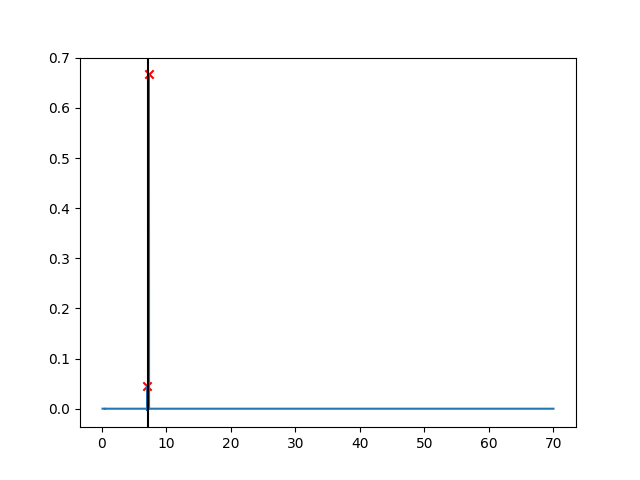

In [15]:
fig = plt.figure()

plt.plot(x[10:], r[-100, 10:])

b = main_peak[-100, 1]
a = second_peak[-100, 1]
mean = 0.5 * (b+a)

plt.scatter([b, a], [ r[-100, int(main_peak[-100, 2])], r[-100, int(second_peak[-100, 2])]], marker = 'x', color = 'r')
plt.axvline(mean, color = 'k')

mass = ig.trapezoid(4*np.pi*r[-100, (x<mean)]*x[x<mean]*x[x<mean], x[x<mean])
print(mass)